                                                1. IMPORTS

In [1]:
#Dataframe/numpy
import numpy as np
import pandas as pd
from collections import defaultdict

#os
import csv
import os
from IPython.display import Image
import warnings
warnings.filterwarnings('ignore')

#Graph
import networkx as nx
from node2vec import Node2Vec
from gensim.models import Word2Vec

#Neural Networks
import keras
import tensorflow as tf
from keras.layers import Dense, Dropout,Reshape, Activation
from keras.models import Sequential
from keras.optimizers import SGD
from keras.layers.merge import Concatenate
from keras.utils.vis_utils import plot_model

#Machine learning algorithms
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

#KFold/Metrics
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
import sklearn

 

Using TensorFlow backend.


                                            1. SETTINGS

In [2]:
# Define the number of topics and number of graph embeddings
nb_emb_w2v = 30
nb_topics = 29

#Load the graph embedding model
w2vModel = Word2Vec.load("Files/word2vec_30.model")

                                       2. FORMAT TRAINING DATAFRAME

In [3]:
# Create the training dataframe with columns Node1-Node2-CosSim-[Topics1]-[Topics2]-[Embeddings1]-[Embeddings2]
nlpDataframe = pd.read_csv("Files/nlpTrain.csv")
Link = nlpDataframe.pop('Link')


#Add embeddings columns to the dataframe
for i in range(nb_emb_w2v):
    topic_name = "1_Emb "+ str(i)
    nlpDataframe[topic_name] = 0.0

for i in range(nb_emb_w2v):
    topic_name = "2_Emb "+ str(i)
    nlpDataframe[topic_name] = 0.0 


#Add the graph embeddings values to the dataframe
for index,row in nlpDataframe.iterrows():
    
    if (index == nlpDataframe.shape[0]/2):
        print ("Halfway done...")
        
    idx1 = int(row["Node1"])
    idx2 = int(row["Node2"])
    
    try :
        node1_values = w2vModel[str(idx1)]
    except KeyError:
        node1_values = [0.0 for i in range(nb_emb_w2v)]
    
    try :
        node2_values = w2vModel[str(idx2)]
    except KeyError:
        node2_values = [0.0 for i in range(nb_emb_w2v)]

    for i,(v1,v2) in enumerate(zip(node1_values, node2_values)):
        
        n1_emb_name = "1_Emb "+ str(i)
        n2_emb_name = "2_Emb "+ str(i)
        
        nlpDataframe.at[index, n1_emb_name] = v1
        nlpDataframe.at[index, n2_emb_name] = v2

pop1 = nlpDataframe.pop('Node1')
pop2 = nlpDataframe.pop('Node2')


                                        3. FORMAT TESTING DATAFRAME

In [4]:
# Create the testing dataframe with columns Node1-Node2-CosSim-[Topics1]-[Topics2]-[Embeddings1]-[Embeddings2]
testDataframe = pd.read_csv('Files/nlpTest.csv')

#Add embeddings columns to the dataframe
for i in range(nb_emb_w2v):
    topic_name = "1_Emb "+ str(i)
    testDataframe[topic_name] = 0.0

for i in range(nb_emb_w2v):
    topic_name = "2_Emb "+ str(i)
    testDataframe[topic_name] = 0.0 
    

#Add the graph embeddings values to the dataframe
for index,row in testDataframe.iterrows():
    
    if (index == testDataframe.shape[0]/2):
        print ("Halfway done...")
        
    idx1 = int(row["Node1"])
    idx2 = int(row["Node2"])
    
    try :
        node1_values = w2vModel[str(idx1)]
    except KeyError:
        node1_values = [0.0 for i in range(nb_emb_w2v)]
    
    try :
        node2_values = w2vModel[str(idx2)]
    except KeyError:
        node2_values = [0.0 for i in range(nb_emb_w2v)]

    for i,(v1,v2) in enumerate(zip(node1_values, node2_values)):
        
        n1_emb_name = "1_Emb "+ str(i)
        n2_emb_name = "2_Emb "+ str(i)
        
        testDataframe.at[index, n1_emb_name] = v1
        testDataframe.at[index, n2_emb_name] = v2

        
pop1 = testDataframe.pop('Node1')
pop2 = testDataframe.pop('Node2')

Halfway done...


                                                4. MODELLING
    
4.1 K-NEAREST NEIGHBORS

In [21]:
components = [13,14,15,16,17]
index = 0

kf = KFold(n_splits=5, random_state=110, shuffle=True)# Define the split - into 10 folds 

for train_index, test_index in kf.split(nlpDataframe):
    print("Splitting...")
    X_train, X_test = nlpDataframe.loc[train_index], nlpDataframe.loc[test_index]
    y_train, y_test = Link[train_index], Link[test_index]
    print(X_test.shape)
    
    svd = TruncatedSVD(n_components=components[index])
    
    X_train = svd.fit_transform(X_train)
    X_test = svd.fit_transform(X_test)
    
    neigh = KNeighborsClassifier(n_neighbors= 25,n_jobs = -1)
    print("Fitting...")
    neigh.fit(X_train, y_train)
    print("Prediction...")
    predictions = neigh.predict(X_test)
    f1score = f1_score(predictions, y_test)
    f1scorem = f1_score(predictions, y_test, average = 'macro')
    print("F1-mean: ", f1score, "F1-macro: ", f1scorem)
    
    print("Saving submission")
    predictions = neigh.predict(svd.fit_transform(testDataframe))
    submissionDf = pd.DataFrame()
    submissionDf["predicted"] = predictions.transpose()
    submissionDf.index.name = 'id'
    file_name = "Results/"+str(index)+"KNN.csv"
    submissionDf.to_csv(file_name, encoding='utf-8', index=True)
        
    index = index + 1

Splitting...
(90760, 119)
Fitting...
Prediction...
F1-mean:  0.9219448047269059 F1-macro:  0.8995079221092541
Saving submission
Splitting...
(90760, 119)
Fitting...
Prediction...
F1-mean:  0.903044583044583 F1-macro:  0.8799416925728407
Saving submission
Splitting...
(90759, 119)
Fitting...
Prediction...
F1-mean:  0.9148490916635096 F1-macro:  0.8906220095998707
Saving submission
Splitting...
(90759, 119)
Fitting...
Prediction...
F1-mean:  0.9166463761058357 F1-macro:  0.8928897258773243
Saving submission
Splitting...
(90759, 119)
Fitting...
Prediction...
F1-mean:  0.9115828392936827 F1-macro:  0.8880941989353546
Saving submission


4.2 LOGISTIC REGRESSION

In [20]:
index = 0
kf = KFold(n_splits=5, random_state=110, shuffle=True)# Define the split - into 10 folds 

for train_index, test_index in kf.split(nlpDataframe):
    
    print("Splitting...")
    X_train, X_test = nlpDataframe.loc[train_index], nlpDataframe.loc[test_index]
    y_train, y_test = Link[train_index], Link[test_index]
    
    print("Fitting...")
    model = LogisticRegression().fit(X_train,y_train)
    print("Prediction...")
    predictions = model.predict(X_test)
    f1score = f1_score(predictions, y_test)
    f1scorem = f1_score(predictions, y_test, average = 'macro')
    print("F1-mean: ", f1score, "F1-macro: ", f1scorem)
    
    print("Submission .csv saved") 
    predictions = model.predict(testDataframe)
    submissionDf = pd.DataFrame()
    submissionDf["predicted"] = predictions.transpose()
    submissionDf.index.name = 'id'
    file_name = "Results/"+str(index)+"LOG.csv"
    submissionDf.to_csv(file_name, encoding='utf-8', index=True)
    index = index + 1

Splitting...
Fitting...
Prediction...
F1-mean:  0.890245085502121 F1-macro:  0.8537911370766978
Submission .csv saved
Splitting...
Fitting...
Prediction...
F1-mean:  0.8906537530266345 F1-macro:  0.8539367815835948
Submission .csv saved
Splitting...
Fitting...
Prediction...
F1-mean:  0.8887633606651426 F1-macro:  0.8520100536596502
Submission .csv saved
Splitting...
Fitting...
Prediction...
F1-mean:  0.8910983186493032 F1-macro:  0.8537075915794694
Submission .csv saved
Splitting...
Fitting...
Prediction...
F1-mean:  0.8913839909332911 F1-macro:  0.8543780136363774
Submission .csv saved


4.3 RANDOM FOREST

In [ ]:
estimators = [100,150,200,250,300]
index = 0

kf = KFold(n_splits=5, random_state=110, shuffle=True)# Define the split - into 10 folds 

for train_index, test_index in kf.split(nlpDataframe):
    
    print("Splitting...")
    X_train, X_test = nlpDataframe.loc[train_index], nlpDataframe.loc[test_index]
    y_train, y_test = Link[train_index], Link[test_index]
    
    print("Fitting...")
    model = RandomForestClassifier(n_estimators = estimators[index], random_state=0).fit(X_train,y_train)
    print("Prediction...")
    predictions = model.predict(X_test)
    f1score = f1_score(predictions, y_test)
    f1scorem = f1_score(predictions, y_test, average = 'macro')
    print("F1-mean: ", f1score, "F1-macro: ", f1scorem)
    
    print("Submission .csv saved") 
    predictions = model.predict(testDataframe)
    submissionDf = pd.DataFrame()
    submissionDf["predicted"] = predictions.transpose()
    submissionDf.index.name = 'id'
    file_name = "Results/"+str(index)+"RF.csv"
    submissionDf.to_csv(file_name, encoding='utf-8', index=True)
    index = index + 1

Splitting...
Fitting...
Prediction...
F1-mean:  0.9608125175413976 F1-macro:  0.9473119236201892
Submission .csv saved
Splitting...
Fitting...
Prediction...
F1-mean:  0.9608940504655054 F1-macro:  0.9472958439666969
Submission .csv saved
Splitting...
Fitting...
Prediction...
F1-mean:  0.9599149444678756 F1-macro:  0.9462696860871352
Submission .csv saved
Splitting...
Fitting...


4.4 GRADIENT BOOSTING

In [19]:
estimators = [100,150,200,250,300]
index = 0

kf = KFold(n_splits=5, random_state=110, shuffle=True)# Define the split - into 10 folds 

for train_index, test_index in kf.split(nlpDataframe):
    
    print("Splitting...")
    X_train, X_test = nlpDataframe.loc[train_index], nlpDataframe.loc[test_index]
    y_train, y_test = Link[train_index], Link[test_index]
    
    print("Fitting...")
    model = GradientBoostingClassifier(n_estimators = estimators[index]).fit(X_train,y_train)
    print("Prediction...")
    predictions = model.predict(X_test)
    f1score = f1_score(predictions, y_test)
    f1scorem = f1_score(predictions, y_test, average = 'macro')
    print("F1-mean: ", f1score, "F1-macro: ", f1scorem)
    
    print("Submission .csv saved") 
    predictions = model.predict(testDataframe)
    submissionDf = pd.DataFrame()
    submissionDf["predicted"] = predictions.transpose()
    submissionDf.index.name = 'id'
    file_name = "Results/"+str(index)+"GD.csv"
    submissionDf.to_csv(file_name, encoding='utf-8', index=True)
    index = index + 1
    

Splitting...
Fitting...
Prediction...
F1-mean:  0.9435828947484032 F1-macro:  0.9243738982286184
Submission .csv saved
Splitting...
Fitting...
Prediction...
F1-mean:  0.9516887408488087 F1-macro:  0.9352683189311289
Submission .csv saved
Splitting...
Fitting...
Prediction...
F1-mean:  0.9576580548452517 F1-macro:  0.9435761936879692
Submission .csv saved
Splitting...
Fitting...
Prediction...
F1-mean:  0.9625089869710839 F1-macro:  0.9495635175576396
Submission .csv saved
Splitting...
Fitting...
Prediction...
F1-mean:  0.9640708570826344 F1-macro:  0.9518011516955556
Submission .csv saved


4.4 FIRST NEURAL NETWORK ARCHITECTURE

In [32]:
listModelNeural1 = []
iteration = 0

# Split the training into 10 different datasets (cross validation)
kf = KFold(n_splits=5, random_state=110, shuffle=True)# Define the split - into 10 folds 
 
for train_index, test_index in kf.split(nlpDataframe):
        
    #Create the training,testing X and y frames.
    X_train, X_test = nlpDataframe.loc[train_index], nlpDataframe.loc[test_index]
    y_train, y_test = Link[train_index], Link[test_index]
        
    #Create the neural network architecture
    model = Sequential()
    model.add(Dense(nb_emb_w2v*2 + nb_topics*2 + 1, activation='relu', input_dim = nb_emb_w2v*2 + nb_topics*2 + 1))
    model.add(Dense(70, activation='relu'))
    model.add(Dense(30, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
        
    model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
  
    #Model fitting
    print("Fitting...")
    model.fit(X_train, y_train, epochs=9, batch_size=32)
    #Prediction and F1-scores
    print("Prediction...")
    predictions = model.predict_classes(X_test)
    f1score = f1_score(predictions, y_test)
    f1scorem = f1_score(predictions, y_test, average = 'macro')
    print("F1-mean: ", f1score, "F1-macro: ", f1scorem)
   
        
    #Save the model in case the F1-score is satisfying(To obtain 93.7%, a 0,9738% F1 score-macro was obtained)
    if f1scorem >= 0.97:
        
        print("Submission .csv saved") 
        predictions = model.predict_classes(testDataframe)
        submissionDf = pd.DataFrame()
        submissionDf["predicted"] = predictions.transpose()[0]
        submissionDf.index.name = 'id'
        file_name = "Results/"+str(iteration)+"N1.csv"
        submissionDf.to_csv(file_name, encoding='utf-8', index=True)
       
    listModelNeural1.append(model)
    iteration = iteration + 1


Fitting...
Epoch 1/9
363037/363037 [==============================] - 21s 58us/step - loss: 0.1236 - acc: 0.9555
Epoch 2/9
363037/363037 [==============================] - 19s 52us/step - loss: 0.0970 - acc: 0.9674
Epoch 3/9
363037/363037 [==============================] - 19s 53us/step - loss: 0.0944 - acc: 0.9697
Epoch 4/9
363037/363037 [==============================] - 20s 54us/step - loss: 0.0916 - acc: 0.9712
Epoch 5/9
363037/363037 [==============================] - 20s 55us/step - loss: 0.0924 - acc: 0.9717
Epoch 6/9
363037/363037 [==============================] - 21s 56us/step - loss: 0.0894 - acc: 0.9722
Epoch 7/9
363037/363037 [==============================] - 19s 52us/step - loss: 0.0863 - acc: 0.9731
Epoch 8/9
363037/363037 [==============================] - 20s 54us/step - loss: 0.0851 - acc: 0.9744
Epoch 9/9
363037/363037 [==============================] - 20s 54us/step - loss: 0.0851 - acc: 0.9748
Prediction...
F1-mean:  0.9733042861835849 F1-macro:  0.963203490174379

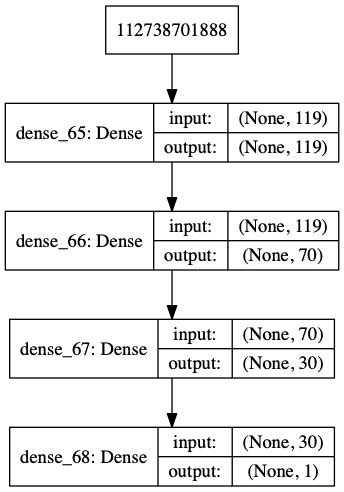

In [41]:
plot_model(listModelNeural1[0], to_file='neural1Architecture.png', show_shapes=True, show_layer_names=True)
Image(filename='neural1Architecture.png')

4.5 SECOND NEURAL NETWORK ARCHITECTURE

4.5.1 Training formatting

In [22]:
# Create the three training dataframes:
# 1. [Topics1]-[Topic2]
# 2. [Embeddings1]-[Embeddings2]
# 3. CosSim

nlpDataframe2 = pd.read_csv("Files/nlpTrain.csv")

Link = nlpDataframe2.pop('Link')
CosSimilarityDf = nlpDataframe2[['Cos_similarity']]
nlpDataframe2.pop('Cos_similarity')

topic_list = []


for i in range(nb_emb_w2v):
    topic_name = "1_Emb "+ str(i)
    topic_list.append(topic_name)

for i in range(nb_emb_w2v):
    topic_name = "2_Emb "+ str(i)
    topic_list.append(topic_name)
    

#Embedding dataframe
embDf = pd.DataFrame(0.0, index=np.arange(nlpDataframe2.shape[0]), columns= topic_list)

listErrorsN1 = []
listErrorsN2 = []

for index,row in nlpDataframe2.iterrows():
    
    if (index == nlpDataframe2.shape[0]/2):
        print ("Halfway done...")
        
    idx1 = int(row["Node1"])
    idx2 = int(row["Node2"])
    
    try :
        node1_values = w2vModel[str(idx1)]
        for i,v in enumerate(node1_values):
            n1_emb_name = "1_Emb "+ str(i)
            embDf.at[index, n1_emb_name] = v
    except KeyError:
        listErrorsN1.append(index)
        
    
    try :
        node2_values = w2vModel[str(idx2)]
        for i,v in enumerate(node2_values):
            n2_emb_name = "2_Emb "+ str(i)
            embDf.at[index, n2_emb_name] = v      
    except KeyError:
        listErrorsN2.append(index)
       


defaultEmb = [0.0 for i in range(nb_emb_w2v)]

pop1 = nlpDataframe2.pop("Node1")
pop2 = nlpDataframe2.pop("Node2")

for index in listErrorsN1:
    for i,v in enumerate(defaultEmb):
        n1_emb_name = "1_Emb "+ str(i)
        embDf.at[index, n1_emb_name] = v

for index in listErrorsN2:
    for i,v in enumerate(defaultEmb):
        n2_emb_name = "2_Emb "+ str(i)
        embDf.at[index, n2_emb_name] = v

4.5.2 Testing formatting

In [23]:

# Create the three testing dataframes:
# 1. [Topics1]-[Topic2]
# 2. [Embeddings1]-[Embeddings2]
# 3. CosSim

nlpTestDataframe = pd.read_csv('Files/nlpTest.csv')
CosSimilarityTestDf = nlpTestDataframe[['Cos_similarity']]
nlpTestDataframe.pop('Cos_similarity')

topic_list = []

for i in range(nb_emb_w2v):
    topic_name = "1_Emb "+ str(i)
    topic_list.append(topic_name)

for i in range(nb_emb_w2v):
    topic_name = "2_Emb "+ str(i)
    topic_list.append(topic_name)
    

embDfTest = pd.DataFrame(0.0, index=np.arange(nlpTestDataframe.shape[0]), columns= topic_list)

listErrorsN1 = []
listErrorsN2 = []

for index,row in nlpTestDataframe.iterrows():
    
    if (index == nlpTestDataframe.shape[0]/2):
        print ("Halfway done...")
        
    idx1 = int(row["Node1"])
    idx2 = int(row["Node2"])
    
    try :
        node1_values = w2vModel[str(idx1)]
        for i,v in enumerate(node1_values):
            n1_emb_name = "1_Emb "+ str(i)
            embDfTest.at[index, n1_emb_name] = v
    except KeyError:
        #print("one error")
        listErrorsN1.append(index)
        #node1_values = [0.0 for i in range(nb_emb_w2v)]
    
    try :
        node2_values = w2vModel[str(idx2)]
        for i,v in enumerate(node2_values):
            n2_emb_name = "2_Emb "+ str(i)
            embDfTest.at[index, n2_emb_name] = v      
    except KeyError:
        #print("one error")
        listErrorsN2.append(index)
        #node2_values = [0.0 for i in range(nb_emb_w2v)]
        
        
defaultEmb = [0.0 for i in range(nb_emb_w2v)]
    
         
pop1 = nlpTestDataframe.pop('Node1')
pop2 = nlpTestDataframe.pop('Node2')

for index in listErrorsN1:
    for i,v in enumerate(defaultEmb):
        n1_emb_name = "1_Emb "+ str(i)
        embDfTest.at[index, n1_emb_name] = v

for index in listErrorsN2:
    for i,v in enumerate(defaultEmb):
        n2_emb_name = "2_Emb "+ str(i)
        embDfTest.at[index, n2_emb_name] = v 

Halfway done...


4.5.3 Fitting

In [31]:
listModelNeural2 = []
iteration = 0

kf = KFold(n_splits=5, random_state=100, shuffle=True)# Define the split 

for train_index, test_index in kf.split(nlpDataframe2):
    
    nlpDataframe2_train, nlpDataframe2_test = nlpDataframe2.loc[train_index], nlpDataframe2.loc[test_index]
    embDf_train, embDf_test = embDf.loc[train_index], embDf.loc[test_index]
    Cos_similarity_train, Cos_similarity_test = CosSimilarityDf.loc[train_index], CosSimilarityDf.loc[test_index]
    
    y_train, y_test = Link[train_index], Link[test_index]
    
    input1 = keras.layers.Input(shape = (nlpDataframe2_train.shape[1],))
    x1 = keras.layers.Dense(100, activation = 'relu')(input1)
    x1 = keras.layers.Dense(10,activation='sigmoid')(x1)

    input2 = keras.layers.Input(shape = (embDf_train.shape[1],))
    x2 = keras.layers.Dense(100, activation = 'relu')(input2)
    x2 = keras.layers.Dense(10,activation='sigmoid')(x2)

    input3 = keras.layers.Input(shape =(1,))

    added = keras.layers.Add()([x1, x2,input3])
    out = keras.layers.Dense(1,activation='sigmoid')(added)

    model = keras.models.Model(inputs=[input1, input2,input3], outputs=out)
    model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy'])

    print("Fitting...")
    model.fit([nlpDataframe2_train, embDf_train, Cos_similarity_train], y_train, batch_size = 32, nb_epoch = 10, verbose = 1)
    
    print("Prediction...")
    predictions = model.predict([nlpDataframe2_test,embDf_test, Cos_similarity_test])
    predictions = np.around(predictions).astype(int)
    f1score = f1_score(predictions, y_test)
    f1scorem = f1_score(predictions, y_test, average = 'macro')
    print("F1-mean: ", f1score, "F1-macro: ", f1scorem)
    
    #Save the model in case the F1-score is satisfying(To obtain 93.7%, a 0,9738% F1 score was obtained)
    if f1scorem >= 0.97:
        print("Submission .csv saved") 
        predictions = model.predict([nlpTestDataframe,embDfTest,CosSimilarityTestDf])
        predictions = np.around(predictions).astype(int)
        submissionDf = pd.DataFrame()
        submissionDf["predicted"] = predictions.transpose()[0]
        submissionDf.index.name = 'id'
        file_name = "Results/"+str(iteration)+"N2.csv"
        submissionDf.to_csv(file_name, encoding='utf-8', index=True)

    iteration = iteration + 1
    listModelNeural2.append(model)

Fitting...
Epoch 1/10
363037/363037 [==============================] - 19s 52us/step - loss: 0.1340 - acc: 0.9530
Epoch 2/10
363037/363037 [==============================] - 20s 54us/step - loss: 0.0922 - acc: 0.9683
Epoch 3/10
363037/363037 [==============================] - 19s 52us/step - loss: 0.0842 - acc: 0.9717
Epoch 4/10
363037/363037 [==============================] - 19s 51us/step - loss: 0.0803 - acc: 0.9733
Epoch 5/10
363037/363037 [==============================] - 19s 53us/step - loss: 0.0779 - acc: 0.9743
Epoch 6/10
363037/363037 [==============================] - 19s 52us/step - loss: 0.0752 - acc: 0.9754
Epoch 7/10
363037/363037 [==============================] - 17s 47us/step - loss: 0.0738 - acc: 0.9759
Epoch 8/10
363037/363037 [==============================] - 16s 45us/step - loss: 0.0722 - acc: 0.9766
Epoch 9/10
363037/363037 [==============================] - 16s 45us/step - loss: 0.0708 - acc: 0.9772
Epoch 10/10
363037/363037 [==============================] - 1

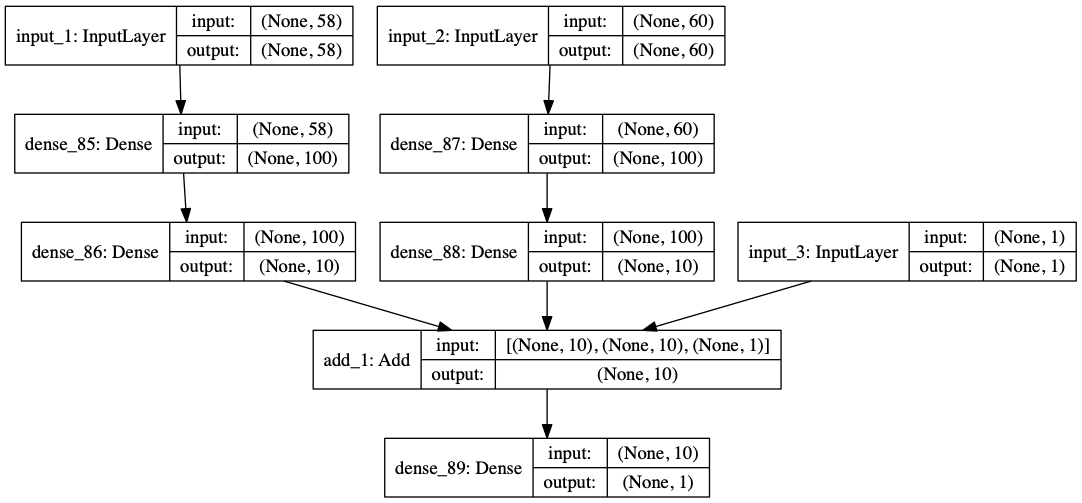

In [45]:
plot_model(listModelNeural2[0], to_file='neural2Architecture.png', show_shapes=True, show_layer_names=True)
Image(filename='neural2Architecture.png')